# Ranking each cluster algorithm

After getting the optimal $n$ cluster, we need to discover what is the best 
clustering algorithm through counting and ranking, then we point two targets
against the metadataset

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics.cluster import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from src.cluster import KMedoids, FCM
from src.metrics import wgss_score, dunn_score, sd_dis_score
from src.ranking.vector_measures import (
    get_n_groups_elbow_technique,
    get_n_groups_information_criteria,
    get_n_groups_max_diff,
    get_n_groups_min_diff
)

First we instatiate the `MinMaxScaler` and set a new range of $n$ clusters

In [4]:
min_nc, max_nc, step = 2, 16, 2
mms = MinMaxScaler()

In [5]:
iris, target = load_iris(return_X_y = True)
scaled_iris = mms.fit_transform(iris)

## Get the optimal $n$ clusters for each clustering algorithm 

### AIC and BIC

In [6]:
ng_aic, index_aic = get_n_groups_information_criteria(scaled_iris, 'aic', min_nc, max_nc, step)
ng_bic, index_bic = get_n_groups_information_criteria(scaled_iris, 'bic', min_nc, max_nc, step)

### K-Means

In [7]:
kmeans_ng, kmeans_index = get_n_groups_elbow_technique(scaled_iris, KMeans, min_nc, max_nc, step)
kmeans_ng_dunn, kmeans_index_dunn = get_n_groups_max_diff(scaled_iris, KMeans, 'dunn', min_nc, max_nc, step)
kmeans_ng_sil, kmeans_index_sil = get_n_groups_max_diff(scaled_iris, KMeans, 'sil', min_nc, max_nc, step)
kmeans_ng_davies, kmeans_index_davies = get_n_groups_min_diff(scaled_iris, KMeans, 'davies', min_nc, max_nc, step)
kmeans_ng_sddis, kmeans_index_sddis = get_n_groups_min_diff(scaled_iris, KMeans, 'sddis', min_nc, max_nc, step)

### K-Medoids

In [8]:
kmedoids_ng, kmedoids_index = get_n_groups_elbow_technique(scaled_iris, KMedoids, min_nc, max_nc, step)
kmedoids_ng_dunn, kmedoids_index_dunn = get_n_groups_max_diff(scaled_iris, KMedoids, 'dunn', min_nc, max_nc, step)
kmedoids_ng_sil, kmedoids_index_sil = get_n_groups_max_diff(scaled_iris, KMedoids, 'sil', min_nc, max_nc, step)
kmedoids_ng_davies, kmedoids_index_davies = get_n_groups_min_diff(scaled_iris, KMedoids, 'davies', min_nc, max_nc, step)
kmedoids_ng_sddis, kmedoids_index_sddis = get_n_groups_min_diff(scaled_iris, KMedoids, 'sddis', min_nc, max_nc, step)

### Fuzzy C-Means

In [9]:
fuzzy_ng, fuzzy_index = get_n_groups_elbow_technique(scaled_iris, FCM, min_nc, max_nc, step)
fuzzy_ng_dunn, fuzzy_index_dunn = get_n_groups_max_diff(scaled_iris, FCM, 'dunn', min_nc, max_nc, step)
fuzzy_ng_sil, fuzzy_index_sil = get_n_groups_max_diff(scaled_iris, FCM, 'sil', min_nc, max_nc, step)
fuzzy_ng_davies, fuzzy_index_davies = get_n_groups_min_diff(scaled_iris, FCM, 'davies', min_nc, max_nc, step)
fuzzy_ng_sddis, fuzzy_index_sddis = get_n_groups_min_diff(scaled_iris, FCM, 'sddis', min_nc, max_nc, step)

Here we generate a `pandas` Dataframe to store the $n$ clusters found for each metric.

In [10]:
df_index_metrics = ['AIC','BIC','Elbow','Dunn','Silhouette','Davies-Bouldin','SD-Dis']
df_columns = ['K-Means','K-Medoids','Fuzzy C-Means']
df = pd.DataFrame(
    data = list(zip(
        [ng_aic, ng_bic, kmeans_ng, kmeans_ng_dunn, kmeans_ng_sil, kmeans_ng_davies, kmeans_ng_sddis],
        [ng_aic, ng_bic, kmedoids_ng, kmedoids_ng_dunn, kmedoids_ng_sil, kmedoids_ng_davies, kmedoids_ng_sddis],
        [ng_aic, ng_bic, fuzzy_ng, fuzzy_ng_dunn, fuzzy_ng_sil, fuzzy_ng_davies, fuzzy_ng_sddis]
    ))
    ,
    index = df_index_metrics, 
    columns = df_columns
)

Here we count the appearing of a n cluster in each metrics for each cluster

In [11]:
df['K-Means'].value_counts().rank(ascending=False,method='min').astype('uint8')

2     1
12    2
8     2
Name: K-Means, dtype: uint8

In [12]:
df['K-Medoids'].value_counts().rank(ascending=False,method='min').astype('uint8')

2     1
12    2
8     2
Name: K-Medoids, dtype: uint8

In [13]:
df['Fuzzy C-Means'].value_counts().rank(ascending=False,method='min').astype('uint8')

2     1
8     2
12    3
Name: Fuzzy C-Means, dtype: uint8

Once found the rankings of each number of cluster, we get this information to compare the cluster algorithms against the metrics again with the optimal $n$ cluster.

To skip some steps, i already know the best number of clusters to each algorithm is 2, however in another scenarios we need to adapt to accept other numbers.

In [14]:
default_params = {'n_clusters': 2,'random_state': 42}
km = KMeans(**default_params)
kmd = KMedoids(**default_params, init = 'kmedoids++')
fcm = FCM(**default_params)

y_pred_km = km.fit_predict(scaled_iris)
y_pred_kmd = kmd.fit_predict(scaled_iris)
y_pred_fcm = fcm.fit_predict(scaled_iris) 

A dictionary is used to store the metrics to calculate again with the clusters algorithm

In [22]:
metrics_dict = dict(
    elbow = [
        wgss_score(scaled_iris, y_pred_km),
        wgss_score(scaled_iris, y_pred_kmd), 
        wgss_score(scaled_iris, y_pred_fcm)
    ],
    dunn = [
        dunn_score(scaled_iris, y_pred_km), 
        dunn_score(scaled_iris, y_pred_kmd), 
        dunn_score(scaled_iris, y_pred_fcm)
    ],
    silhouette = [
        silhouette_score(scaled_iris, y_pred_km), 
        silhouette_score(scaled_iris, y_pred_kmd), 
        silhouette_score(scaled_iris, y_pred_fcm)
    ],
    davies_bouldin = [
        davies_bouldin_score(scaled_iris, y_pred_km),
        davies_bouldin_score(scaled_iris, y_pred_kmd),
        davies_bouldin_score(scaled_iris, y_pred_fcm)
    ],
    sddis = [
        sd_dis_score(scaled_iris, y_pred_km),
        sd_dis_score(scaled_iris, y_pred_kmd),
        sd_dis_score(scaled_iris, y_pred_fcm)
    ]
)

In next section we plot the results to compare again.

# Elbow Method

<AxesSubplot:>

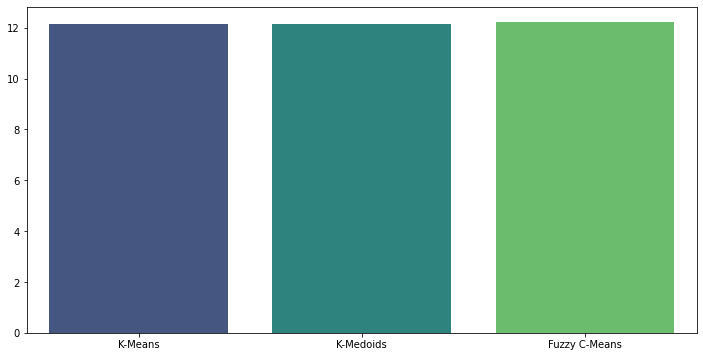

In [16]:
l_wgss = metrics_dict['elbow']

plt.figure(figsize = (12, 6))
sns.barplot(x = df_columns,y = l_wgss, palette = 'viridis')

# Dunn Score

<AxesSubplot:>

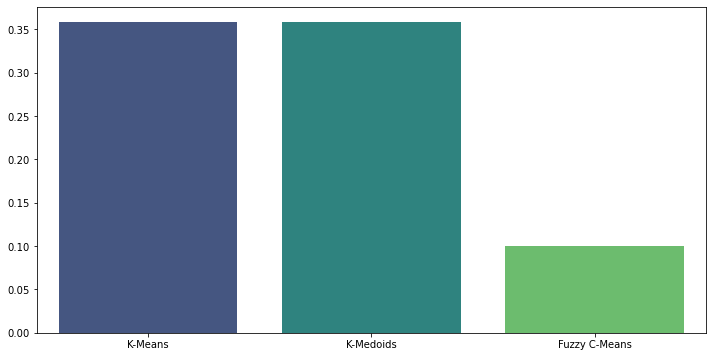

In [17]:
l_dunn = metrics_dict['dunn']

plt.figure(figsize = (12,6))
sns.barplot(x = df_columns,y = l_dunn, palette = 'viridis')

# Silhouette Score

<AxesSubplot:>

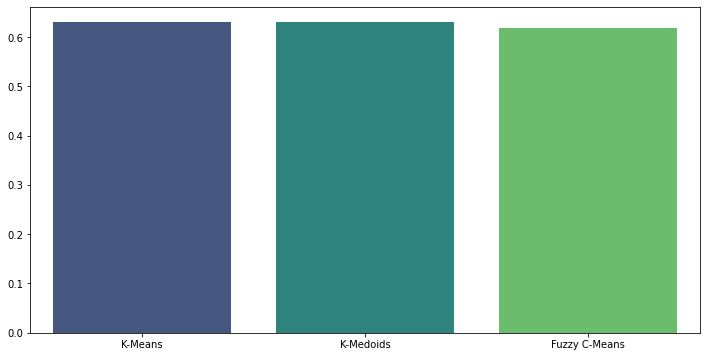

In [23]:
l_sil = metrics_dict['silhouette']

plt.figure(figsize=(12,6))
sns.barplot(x=df_columns,y=l_sil,palette='viridis')

# Davies-Bouldin Score

<AxesSubplot:>

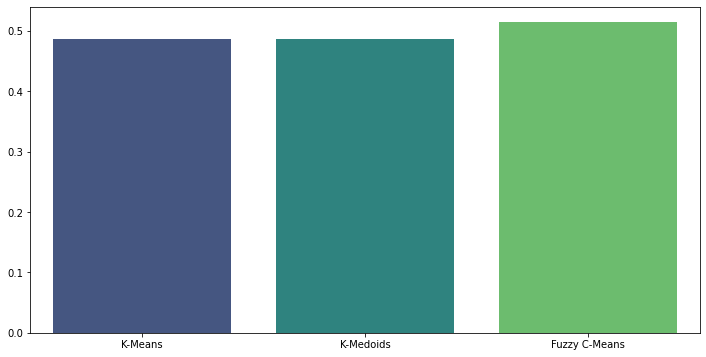

In [24]:
l_davies = metrics_dict['davies_bouldin']

plt.figure(figsize = (12,6))
sns.barplot(x = df_columns, y = l_davies, palette = 'viridis')

# SD-Distance Score

<AxesSubplot:>

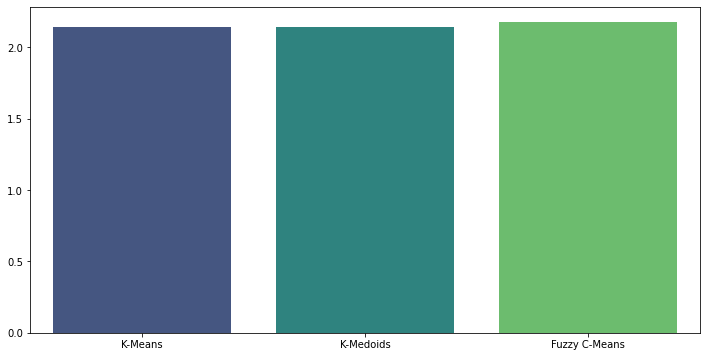

In [25]:
l_sddis = metrics_dict['sddis']

plt.figure(figsize=(12,6))
sns.barplot(x=df_columns,y=l_sddis,palette='viridis')

In [26]:
df_cluster_algo = pd.DataFrame.from_dict(data = metrics_dict,orient='index',columns = df_columns)
df_cluster_algo

,K-Means,K-Medoids,Fuzzy C-Means
elbow,12.127791,12.127791,12.217183
dunn,0.358112,0.358112,0.100247
silhouette,0.630047,0.630047,0.618403
davies_bouldin,0.486167,0.486167,0.514449
sddis,2.142810,2.142810,2.176166


In [68]:
df_final_rank = pd.DataFrame(columns = df_columns, index = list(metrics_dict.keys()))
for i in df_cluster_algo.index.values.tolist():
    if i=='silhouette' or i == 'dunn':
        df_final_rank.loc[[i]] = df_cluster_algo.loc[[i]].rank(axis='columns',ascending=False,method='min')
    if i == 'davies_bouldin' or i == 'sddis' or i == 'elbow':
        df_final_rank.loc[[i]] = df_cluster_algo.loc[[i]].rank(axis='columns',ascending=True,method='min')
df_final_rank

,K-Means,K-Medoids,Fuzzy C-Means
elbow,1,1,3
dunn,1,1,3
silhouette,1,1,3
davies_bouldin,1,1,3
sddis,1,1,3


In [72]:
df_final_rank.mean()

K-Means          1.0
K-Medoids        1.0
Fuzzy C-Means    3.0
dtype: float64

# Final result

As you can see in the Iris Dataset, the best algorithm is K-Means with 2 cluster or K-Medoids with the same number of clusters.

In [80]:
df_winner = pd.DataFrame(
    columns = [df_final_rank.mean().rank(ascending=True,method='min').idxmin()],
    data = [df_final_rank.mean().rank(ascending=True, method='min').min()]
)
df_winner

,K-Means
0,1.0
